# How to Random Walk
a short tutorial about Random Walks (and variants of), part 2.

---

The idea behind this tutorial is to make accessible both theoretical results
and computational ideas in an intuitive way. 
The formalism from algebraic graph theory makes expressing ideas simple, 
once the notation is acquired. So we will start with a short introduction on 
graph theory and their matrix representation.

## Introduction to algebraic notation

A graph $G = (V,E)$ is made of a set of **vertices** $V$ and of **edges** $E$. We will only be considering connected graphs.

Vertices are the nodes of the network, so $V$ is the set of nodes.

Edges are the link which connects the nodes, so an edge $e$ between 
two nodes $v_0$ and $v_1$ is the pair of said nodes $e = (v_0,v_1)$.

The order is of importance if the graph is **directed**. 

For the sake of convenience, let's say that there are $n=|V|$ nodes and let's label the nodes with integers so that $V = \{ v_0, v_1, ..., v_{n-1}\}$.

Let's also say that there are $m = |E|$ edges in the graph.

For a **weighted** graph $G_{\text{weighted}} = (V,E,w)$ we would also have a function $w : E \rightarrow \mathbb{R}$ which assigns a weight to each edge of the graph. That is the weight of edge $e$ would be $w(e)$.

### Adjacency matrix

For a given graph $G = (V,E)$ we can consider the square matrix $A$ of size $n$,
where on column $i$ and row $j$ we have $A_{i,j} = w((v_i,v_j))$ if the edge $(v_1,v_j)$ exists and $0$ if it doesn't.
$$ A_{i,j} = \begin{cases}
    w((v_i,v_j)),& \text{if } (v_i,v_j) \in E\\
    0,              & \text{otherwise}
\end{cases}$$

This is the **adjacency matrix**.

Conversely, for any square matrix A there is a weighted graph for which A is the adjacency matrix.

### Diagonal degree matrix

For a given graph $G = (V,E=$ we can consider the square matrix $D$ of size $n$, 
which is full of zeros except on the diagonal where 
$$D_{i,i} = d_i = \sum_{j=0}^{n-1}w((e_i,e_j))$$
if the graph is directed this corresponds to the out-degree (the in-degree is similar with indices $i$ and $j$ inverted inside the sum).

### Vectors 

In this context what is a vector of size $n$ ? It is an object which stores for each node of the graph a certain numerical quantity. So it can be viewed as a function on the space of nodes.

For example, the vector $\mathbb{1} = (1, 1, ..., 1)^T$ of size $n$ is the vector which equals 1 for all nodes of the graph. The vector $p_0 = (1, 0, ..., 0)^T$ is the vector which only equals 1 at node $v_0$ and 0 elsewhere.

Vectors whose values are non-negative and which sum to 1 are probability distributions over the nodes of the graph. In this sense the vector $p_0$ is the point distribution on node $v_0$.

## I. Random Walk
Given a graph $G=(V,E)$, the random walk problem consists in computing the position of an element, which would start at a given position and would randomly walk along the edges of the graph, after a certain number of time-steps. At each time step the element is required to move randomly, that is choosing an edge *at random*. In some cases, the choice of the edge is made uniformly from the set of edges available. Sometimes a correction is used. Let's assume the walk starts at node $v_0$ (without loss of generality because we can relabel the nodes). Let's call $v_{t=i}$ the node on which the element is at timestep $i$. Then P verifies
$$
\begin{align}
v_{t=0} &= v_0 \\
v_{t=i+1} &= \text{ random element from } \{v \text{ such that } (v_{t=i},v) \in E \} 
\end{align}
$$

At each time step $i$ we are interested in the possible values (positions in the graph) for $v_{t=i}$ and with what probability they occur. The first idea that comes to mind to answer this question is to simulate the random walk enough times and average the results of the different runs.

**Exemple 1 : A one dimensional walk**

Let's have $V = \{0,...,n-1\}$ and edges between nodes that are one integer apart, that is to say $E = \{ (x,y) \text{ such that } |x-y| = 1 \}$. 

Let's also assume, as will often be the case, that the graph is unweighted and therefore the random walk will move to a neighbour with equiprobability on the choice of the neighbor.
Later, we will want to move away from the equiprobability assumption and we will introduce a **bias** i.e a deviation from the equiprobability.

In [1]:
import networkx as nx
import numpy as np 
import matplotlib.pyplot as plt 

%matplotlib widget

import ipywidgets as wd
from ipywidgets import interactive

from tutoUtils import *

In [2]:
SIZE = np.array([12,6])
rescale = 0.5

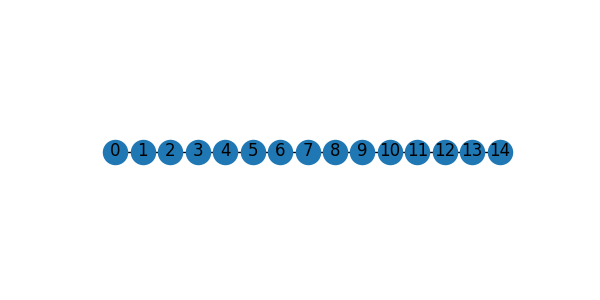

In [3]:
n = 15
V = list(range(n))
E = {0:[1]} | {n-1:[n-2]} | {i:[i-1,i+1] for i in range(1,n-1)}  
G_1D = nx.from_dict_of_lists(E)
pos_line = {i:[2*i,0] for i in list(G_1D)}
pos_cercle = {i:[np.cos(2*i*np.pi/n),np.sin(2*i*np.pi/n)] for i in list(G_1D)}

f,ax = plt.subplots(1,1, figsize=rescale*SIZE)
nx.draw(G_1D, pos=pos_line, ax=ax, with_labels = True)

We will now implement the functions which will simulate the random walk, this will be our first strategy though not most efficient, of computing the probabilities of presence on each node after a given time step.

- The function **choose_next** chooses at random (equiprobable) a neighbor of a given node.
- The function **run** simulates a trajectory of the random walk for a given number of timesteps.
- The function **sample** calls the function **run** a specified number of times, storing where each run ends up. It outputs an estimate of the distribution of presence. 

In [4]:
import random
import matplotlib.pyplot as plt

time = 14
N = 100

def choose_next(node,G):
    return random.choice(list(G.neighbors(node)))

def run(G,initial,time):
    current = initial
    for t in range(time):
        current = choose_next(current,G)
    return current

def sample(N,G,initial,time):
    T = {i:0 for i in G.nodes()}
    for _ in range(N):
        current_run = run(G,initial,time)
        T[current_run] +=1
    for key,val in T.items():
        T[key] = val/N
    return T


So let's simulate the random walk :

In [5]:
def plot_network(P,ax):
    size_P = 20*100*np.array([P[i] for i in list(G_1D)])
    nx.draw(G_1D, pos=pos_line,ax=ax, with_labels=True, node_size = size_P )
    return ax

def plot_distrib(P,ax):
    ax.plot(range(n),P)
    for i,x in zip(range(n),P):
        ax.text(i,x,f'{x:.2f}')
    return ax

def interact_sim(N,initial,time,seed=1):
    # Preparing figure
    f = plt.figure(figsize = rescale*SIZE)
    gs = f.add_gridspec(3, 2)
    ax0 = f.add_subplot(gs[0,:])
    ax1 = f.add_subplot(gs[1:,:])
    
    # Running simulation
    random.seed(seed)
    T = sample(N,G_1D,initial,time)
    P = [T[i] for i in range(n)]

    # Plotting and showing 
    plot_network(P,ax0)
    plot_distrib(P,ax1)
    plt.show()

interactive(interact_sim,   N = wd.IntSlider(min=20, max=2000, step=10, value=100),\
                            initial = wd.IntSlider(min=0, max=14, step=1, value=0),\
                            time = wd.IntSlider(min=0, max=100, step=1, value=14), seed = wd.fixed(1))

interactive(children=(IntSlider(value=100, description='N', max=2000, min=20, step=10), IntSlider(value=0, des…

Let's try another way of plotting without rebuilding a figure every time.

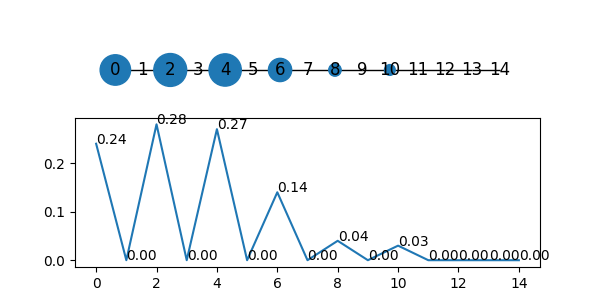

interactive(children=(IntSlider(value=100, description='N', max=2000, min=20, step=10), IntSlider(value=0, des…

In [6]:
def initialize_figure(N,initial,time,seed=1):
    #plt.ion()
    # Preparing figure
    f = plt.figure(figsize = rescale*SIZE)
    gs = f.add_gridspec(3, 2)
    ax0 = f.add_subplot(gs[0,:])
    ax1 = f.add_subplot(gs[1:,:])

    # Running simulation
    random.seed(seed)
    T = sample(N,G_1D,initial,time)
    P = [T[i] for i in range(n)]

    # Plot network
    size_P = 20*100*np.array([P[i] for i in list(G_1D)])
    node_collection = my_draw(G_1D, pos=pos_line,ax=ax0, with_labels=True, node_size = size_P )
    
    # Plot distrib
    line1, = ax1.plot(range(n),P)
    texts = []
    for i,x in zip(range(n),P):
        tmp = ax1.text(i,x,f'{x:.2f}')
        texts.append(tmp)
        
    plt.show()
    return f,[ax0,ax1],[node_collection,line1,texts]

def update_network(P,node_collection):
    size_P = 20*100*np.array([P[i] for i in list(G_1D)])
    node_collection.set_sizes(size_P)

def update_distrib(P,line1,texts):
    line1.set_ydata(P)
    for t,x in zip(texts,P):
        t.set_text(f'{x:.2f}')
        t.set_y(x)
    
def interact_sim(N,initial,time,f,axes,upds,seed=1):
    # Runnning simulation
    random.seed(seed)
    T = sample(N,G_1D,initial,time)
    P = [T[i] for i in range(n)]
    
    update_network(P,upds[0])
    update_distrib(P,upds[1],upds[2])
    
    axes[1].relim()
    axes[1].autoscale_view()
    
    f.canvas.draw_idle()
    
figlin,axeslin,updatables = initialize_figure(100,0,14)

interactive(lambda N,initial,time : interact_sim(N,initial,time,figlin,axeslin,updatables),\
                            N = wd.IntSlider(min=20, max=2000, step=10, value=100),\
                            initial = wd.IntSlider(min=0, max=14, step=1, value=0),\
                            time = wd.IntSlider(min=0, max=100, step=1, value=14))

### We see that there are a couple problems: 

The run should reach the end of the line in some cases. Which means we didn't simulate enough runs (here $N=100$ but you can change the value). 

The oscillation behaviour between odd and even timesteps (have a look at it using the time bar), coming from the priodicity of the graph it is not a problem in general but arises in simple context (the probability of a graph being periodic becomes very small when the graph is large). With Random Walk with Restart this is not a problem, the graph resulting from adding the restart cannot be periodic.

### Computing directly on the distribution of presence rather than simulating the runs

Instead of looking at independant runs, we have simple equations for the evolution of the probability distribution of presence.

That is if we now have $p_{i}$ a probability of presence : $p_{i}[k] = \mathbb{P}(v_{t=i} = k)$. That is the probability that at time $i$ the element is on node $k$.

How does p evolve at each time step ? It's evolution can be put in equation quite simply :
$$
p_{i+1} = A D^{-1}p_{i}
$$

In [7]:
def random_walk(G,initial,time):
    n = len(G.nodes)
    A = nx.adjacency_matrix(G)
    S = A.sum(axis=0)
    D = np.diag([S[0,i] for i in range(n)])
    D_inv = np.linalg.inv(D)
    curr = initial.copy()
    for _ in range(time):
        curr = A@D_inv@curr
    return curr

In [8]:
def order_vector(G,v):
    tmp = np.zeros(len(v))
    for i,node in enumerate(list(G)):
        tmp[node] = v[i]
    return tmp

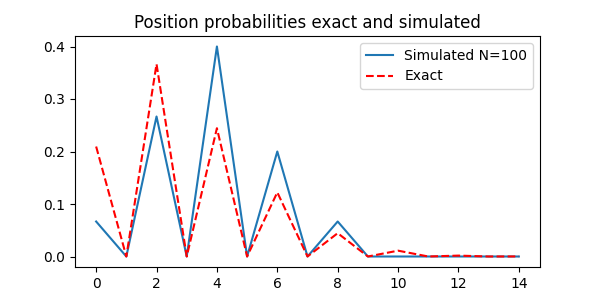

In [9]:
initial = np.zeros(n)
initial[0] = 1
time = 14
P_alg = random_walk(G_1D,initial,time)
P_alg = order_vector(G_1D,P_alg)
P_sim = sample(n,G_1D,0,time)
P_sim = [P_sim[i] for i in range(n)]
f, ax = plt.subplots(1,1, figsize = rescale*SIZE)
ax.set_title('Position probabilities exact and simulated')
ax.plot(P_sim, label = 'Simulated N=100')
ax.plot(P_alg, c = 'red', ls = '--',label = 'Exact')
ax.legend()

Okay, so we get a method to compute the **exact** probability distribution at a given time step. We will now show that the sampling strategy does indeed converge to the exact distribution. We will then look at what happens on the long run, what happens to the distribution after **many** time steps. Apart from the periodic graphs, where the distribution oscillates, the distribution reaches a limit distribution. This distribution can be computed independently, we will give the theoretical limit and try to give som insights regarding this limit distribution.

Let's use another more complex graph, one we hope will not be periodic. Let's use a randomly generated graph (a very interesting graph field of study as matters). Let's choose a reasonnable size for it (so that we can plot it and still see something, graph drawing can get very messy with big and complex graphs).

## A more complex graph

We will use a configuration model (a technique to produce a graph from a list of vertex degrees). We will therefore generate the degrees from a powerlaw distribution first and feed these to the configuration model. We remove duplicated edges and self-loops.

In [10]:
while True:
    vals = nx.utils.powerlaw_sequence(100,1.5)
    vals = [int(l) for l in vals]
    if not (np.sum(vals) % 2):
        break
        
G_powerlaw = nx.configuration_model(vals)
G_powerlaw = nx.Graph(G_powerlaw) # remove parallel edges
G_powerlaw.remove_edges_from(nx.selfloop_edges(G_powerlaw))

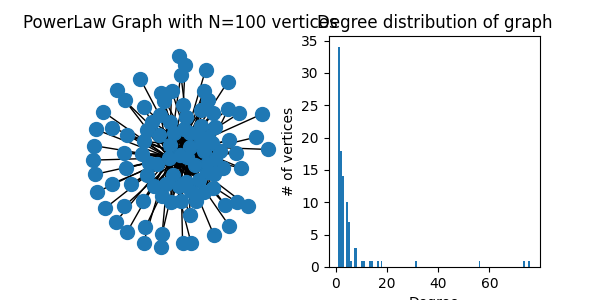

In [11]:
f, axes = plt.subplots(1,2, figsize = rescale*SIZE)
pos_pwrlaw = nx.spring_layout(G_powerlaw)
nx.draw(G_powerlaw,pos=pos_pwrlaw, ax=axes[0], node_size = 100)
l = [deg for x,deg in list(G_powerlaw.degree)]
_ = axes[1].hist(l,bins=100)
_ = axes[0].set_title(f"PowerLaw Graph with N={len(G_powerlaw)} vertices")
_ = axes[1].set_title("Degree distribution of graph")
_ = axes[1].set_ylabel("# of vertices")
_ = axes[1].set_xlabel("Degree")

### Showing that the sampling strategy converges to the exact solution

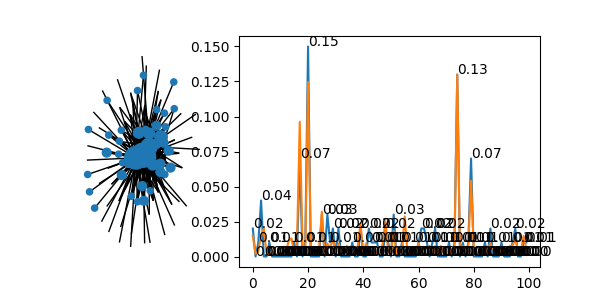

interactive(children=(IntSlider(value=100, description='N', max=2000, min=20, step=10), Output()), _dom_classe…

In [12]:
def initialize_figure(N,initial,time,G,pos,seed=1):
    #plt.ion()
    # Preparing figure
    f = plt.figure(figsize = rescale*SIZE)
    gs = f.add_gridspec(2, 3)
    ax0 = f.add_subplot(gs[:,:1])
    ax1 = f.add_subplot(gs[:,1:])

    # Running simulation
    random.seed(seed)
    T = sample(N,G,initial,time)
    P = [T[i] for i in range(len(G))]

    # Computing exact distribution
    ini_vec = np.zeros(len(G))
    ini_vec[initial] = 1
    P_alg = random_walk(G,ini_vec,time)
    P_alg = order_vector(G,P_alg)
    
    # Plot network
    size_P = 20*100*np.array([P[i] for i in list(G)])
    node_collection = my_draw(G, pos=pos,ax=ax0, with_labels=False, node_size = size_P )
    
    # Plot distrib
    line1, = ax1.plot(range(len(G)),P)
    ax1.plot(range(len(G)),P_alg)
    texts = []
    for i,x in zip(range(len(G)),P):
        tmp = ax1.text(i,x,f'{x:.2f}')
        texts.append(tmp)
        
    plt.show()
    return f,[ax0,ax1],[node_collection,line1,texts]

def update_network(P,G,node_collection):
    size_P = 20*100*np.array([P[i] for i in list(G)])
    node_collection.set_sizes(size_P)

def update_distrib(P,line1,texts):
    line1.set_ydata(P)
    for t,x in zip(texts,P):
        if int(x*100) >= 3:
            t.set_text(f'{x:.2f}')
            t.set_y(x)
        else:
            t.set_text('')
    
def interact_sim(N,initial,time,f,axes,upds,G,seed=1):
    # Runnning simulation
    random.seed(seed)
    T = sample(N,G,initial,time)
    P = [T[i] for i in range(len(G))]
    
    update_network(P,G,upds[0])
    update_distrib(P,upds[1],upds[2])
    
    axes[1].relim()
    axes[1].autoscale_view()
    
    f.canvas.draw_idle()
    
figlin,axeslin,updatables = initialize_figure(100,0,14,G_powerlaw,pos_pwrlaw)

interactive(lambda N,initial,time : interact_sim(N,initial,time,figlin,axeslin,updatables,G_powerlaw),\
                            N = wd.IntSlider(min=20, max=2000, step=10, value=100),\
                            initial = wd.fixed(50),\
                            time = wd.fixed(15))

Here the duration of the walk is fixed (time = 15), the starting vertex is also fixed, we only vary the number of samples we use to compute the distribution.
By varying N, you see that the more you sample from the random walk, the closest you get to the exact distribution. In this sense, the sampling simulation procedure does converge to the exact distribution.

One final plot to show this, and we'll stop talking about simulations : let's plot the error between the simulated random walk and the exact distribution as N grows.

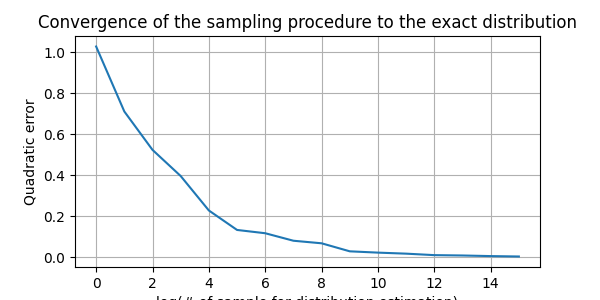

In [13]:
SIZE_MAX = 16
Ns = [2**k for k in range(SIZE_MAX)]
initial = 12
time = 15
# Computing exact distribution
ini_vec = np.zeros(len(G_powerlaw))
ini_vec[initial] = 1
P_alg = random_walk(G_powerlaw,ini_vec,time)
P_alg = order_vector(G_powerlaw,P_alg)

Errors = []

for N in Ns:
    # Running simulation
    T = sample(N,G_powerlaw,initial,time)
    P = np.array([T[i] for i in range(len(G_powerlaw))])
    Errors.append(np.linalg.norm(P_alg-P))

f, ax = plt.subplots(1,1, figsize = rescale*SIZE)
ax.plot(range(SIZE_MAX),Errors)
ax.grid(which='major')
ax.set_ylabel('Quadratic error')
ax.set_xlabel('log(# of sample for distribution estimation)')
_ = ax.set_title('Convergence of the sampling procedure to the exact distribution')

## What happens on the long run ?

If we look at the probability of presence of the random walk as time goes to infinity, we see that it reaches (in most cases) a stationnary distribution.

That is to say :

$\lim_{i \rightarrow +\infty} p_i = S$

This is a standard result of Markov Chain Theory and follows from the Perron-Froebenius theorem.

What does S look like for a random walk ? There is a pretty straightforward formula : 
$$ S_j = \frac{d_j}{2m} $$

Where $d_j$ is the degree of node $j$ and $m$ is the number of edges in the network (considered as undirected), for directed networks the degree becomes the in-degree and $2m$ is replaced by $m$.

We note that the stationnary distribution does not depend on the starting vertex $p_0$, it only depends on the degree of the node. The first remark is quite easy to understand : the starting vertex only influences the beginning of the walk, after a very short walk we know we are still near the starting vertex. As the walk gets longer, we loose the information about where the walk started when we look at our current position. After a very long random walk through the network, all vertices could have been the starting vertices.

Let's show this property on our example graph, we will use the exact method to compute the probability of presence on each vertex for each time point until a time where convergence is reached. We will pre-compute the probabilities of presence, and access the precomputed values when plotting.

We will also show on a plot, the current probability of presence of each vertex (dots on the plot) and the stationnary probabilities (as a $y=\frac{x}{2m}$ red dotted line).

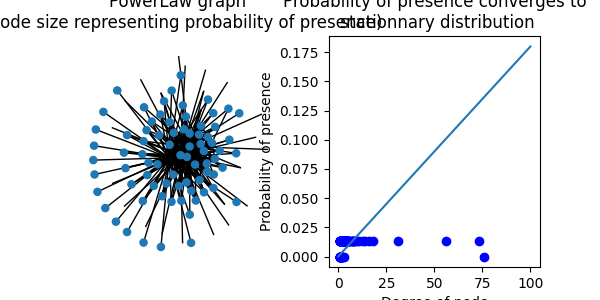

interactive(children=(IntSlider(value=1, description='time', max=36), Output()), _dom_classes=('widget-interac…

In [14]:
INITIAL = 50
ini_vec = np.zeros(len(G_powerlaw))
ini_vec[INITIAL] = 1

def random_walk_all_times(G,initial,eps=1e-3):
    n = len(G.nodes)
    A = nx.adjacency_matrix(G)
    S = A.sum(axis=0)
    stat = np.array([S[0,i] for i in range(n)])
    stat = stat/np.sum(stat)
    D = np.diag([S[0,i] for i in range(n)])
    D_inv = np.linalg.inv(D)
    curr = initial.copy()
    T = []
    while np.linalg.norm(stat-curr) > eps:
        curr = A@D_inv@curr
        T.append(curr.copy())
    return T

ALL_DISTS = random_walk_all_times(G_powerlaw,ini_vec) 



def initialize_figure(G,pos,seed=1):
    #plt.ion()
    # Preparing figure
    f = plt.figure(figsize = rescale*SIZE)
    gs = f.add_gridspec(2, 2)
    ax0 = f.add_subplot(gs[:,:1])
    ax1 = f.add_subplot(gs[:,1:])

    # Computing exact distribution
    P_alg = order_vector(G,ALL_DISTS[1])
    
    # Plot network
    size_P = 20*100*np.array([P_alg[i] for i in list(G)])
    node_collection = my_draw(G, pos=pos,ax=ax0, with_labels=False, node_size = size_P )
    
    # Plot distrib
    A = nx.adjacency_matrix(G)
    X = A.sum(axis=0)
    X = np.array([X[0,i] for i in range(len(G))])
    line1, = ax1.plot(X,P_alg,'bo')
    ax1.plot([0,100],[0,100/np.sum(X)])
    
    # titles and labels
    ax0.set_title('PowerLaw graph \n (node size representing probability of presence)')
    ax1.set_title('Probability of presence converges to\n stationnary distribution')
    ax1.set_xlabel('Degree of node')
    ax1.set_ylabel('Probability of presence')
    
    plt.show()
    return f,[ax0,ax1],[node_collection,line1]

def update_network(P,G,node_collection):
    size_P = 20*100*np.array([P[i] for i in list(G)])
    node_collection.set_sizes(size_P)

def update_distrib(P,line1):
    line1.set_ydata(P)
    
def interact_sim(time,f,axes,upds,G,seed=1):
    
    update_network(ALL_DISTS[time],G,upds[0])
    update_distrib(ALL_DISTS[time],upds[1])
    
    f.canvas.draw_idle()
    
figlin,axeslin,updatables = initialize_figure(G_powerlaw,pos_pwrlaw)

interactive(lambda time : interact_sim(time,figlin,axeslin,updatables,G_powerlaw),\
                            time = wd.IntSlider(min=0, max=len(ALL_DISTS)-1, step=1, value=1))